# ETPF
Require: `x_true_l63_full.npy`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from da.l63 import lorenz63
from da.scheme import rk4
from da.loss import loss_rms
from da.visualize import plot_loss
from da.etpf import EnsembleTransformParticleFilter as ETPF

In [3]:
# params
s = 10
b = 8/3
r = 28

# time step size
dt = 0.01
print("dt:", dt)

# obs_per
obs_per = 12
print("obs_per:", obs_per)

# Dt: 時間刻み
# NOTE: nature runの生成に使ったdtに対して，Dt = dt * obs_perとなるように設定．
Dt = dt * obs_per
print("obs. interval:", Dt)


p = (s, r, b)
# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, Dt):
    for i in range(int(Dt/dt)):
        x = rk4(lorenz63, 0, x, p, dt)
    return x

# 単位行列
I = np.eye(3, dtype=float)

# 観測
H = I
# H = np.eye(2,3)
# H = np.eye(1,3)
print("H:", H)

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((3, 3))

# 観測誤差共分散, 後で定数倍の変化をさせる.
r = 1.0
R = r**2*I
print("r:", r)

# 観測値と真値
end_step = 1000*obs_per # 開発用
x_true = np.load("x_true_l63_full.npy")[:end_step:obs_per]

R = H@R@H.T

# ensemble size
m = 100

# generate initial ensemble
seed = 0
np.random.seed(seed)
x_0 = x_true[np.random.randint(len(x_true)-1)]
P_0 = 64*I

X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)

# inflation
sigma_add = 0.4


dt: 0.01
obs_per: 12
obs. interval: 0.12
H: [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
r: 1.0


In [4]:
# generate observations
y = (H@x_true.T).T
y += np.random.multivariate_normal(mean=np.zeros_like(y[0]), cov=R, size=len(y))

def h(x):
    return H@x


etpf = ETPF(M, h, R, N_thr=.9, add_inflation=sigma_add)
etpf.initialize(X_0)
for y_obs in tqdm(y):
    etpf.forecast(Dt)
    etpf.update(y_obs)

    if False:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(*y_obs, marker='*')
        for x in etpf.X:
            ax.scatter(*x)

        ax.set_xlim([-20, 20])
        ax.set_ylim([-20, 20])
        ax.set_zlim([-20, 20])
        plt.show()
    

x_assim = etpf.x

100%|██████████| 1000/1000 [00:10<00:00, 92.42it/s]


RMSE time average: 0.42966402659925834


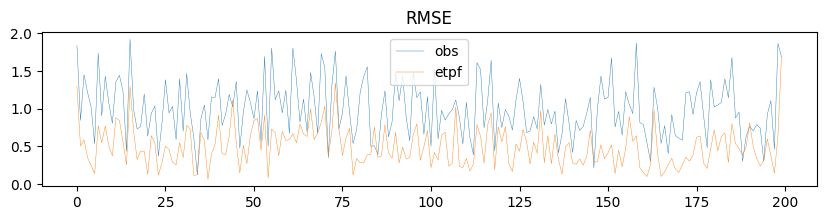

In [9]:
# plot rmse
vis_per = 5
fig, ax = plt.subplots(figsize=(10, 2))
plot_loss(x_true[:end_step:vis_per]@H.T, y[:end_step:vis_per], loss_rms, ax=ax, label='obs', lw=0.3)
plot_loss(x_true[:end_step:vis_per], x_assim[:end_step:vis_per], loss_rms, ax=ax, label='etpf', lw=0.3)
# plt.plot(np.sqrt(pf.trP), lw=0.3, label='trP')
ax.legend()
ax.set_title("RMSE")
# ax.set_xticks(np.arange(0, len(x_true[:end_step:vis_per]), len(x_true[:end_step:vis_per])//vis_per))
# ax.set_xticklabels(np.arange(0, end_step, end_step//vis_per))
print("RMSE time average:", loss_rms(x_true[:end_step], x_assim)[len(x_assim)//4*3:].mean())
# print("RMSE time average:", loss_rms(x_true[:end_step:vis_per]@H.T, y[:end_step:vis_per]).mean())

# m vs. h

In [6]:
# def compute_rmse(simulate_params):
#     # RUN DA
#     m, sigma = simulate_params.values()
#     etpf = ETPF(M, h, R, add_inflation=sigma, N_thr=.9)
#     X_0 = x_0 + np.random.multivariate_normal(np.zeros_like(x_0), P_0, m)  # (m, dim_x)
#     etpf.initialize(X_0)
#     for y_obs in tqdm(y):
#         etpf.forecast(Dt)
#         etpf.update(y_obs)

#     return loss_rms(x_true, etpf.x).mean()

In [7]:
# # from da.params import prod_params_kv
# from da.optimize import grid_search2
# import seaborn as sns

# m_list = [20, 40, 60]
# sigma_list = [0.1, 0.2, 0.4]

# # params_kv = prod_params_kv("m", m_list, "sigma", sigma_list)
# # print(params_kv)

# df = grid_search2(compute_rmse, "m", m_list, "sigma", sigma_list, n_multi=1, multi_type="process")
# sns.heatmap(df, annot=True, fmt=".3g", vmax=r*1.5, vmin=max([0.0, r-1.0]))